In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Polygon
import pickle 
import cv2 as cv

from src.vican.vican.cam import estimate_pose_mp, estimate_pose_charuco_worker
from src.vican.vican.bipgo import bipartite_se3sync, object_bipartite_se3sync
from src.vican.vican.plot import plot2D, plot_cams_3D
from src.vican.vican.geometry import SE3
from src.vican.vican.dataset import Dataset

#make sure jupyter notebook auto reloads imported funtions
%load_ext autoreload
%autoreload 2

# Edit path to the folder containing the renders
DATASET_PATH = "./dataset/optitrack/output_frames"
#DATASET_PATH= "./dataset/big_dataset"
#DATASET_PATH = "./dataset/hitachi_test/mini_data_set"

# Edit path to the folder containing the cube calibration images.
#OBJ_DATASET_PATH = "./dataset/optitrack_videos/output_object"
OBJ_DATASET_PATH = "./dataset/realsense_charuco_object"
#OBJ_DATASET_PATH = "./dataset/hitachi_test/object"
GABRIEL = False

OBJ_DATASET_PATH = "./dataset/gab_paper/small_room_small_cube_obj_calib"
DATASET_PATH = "./dataset/gab_paper/small_room_small_cube"

# gab datasets
if 0:
    GABRIEL= True
    SCALE_GABRIEL = 1

LOAD = False

obj_dataset = Dataset(root=OBJ_DATASET_PATH)
dataset     = Dataset(root=DATASET_PATH)


len(dataset.im_data["filename"])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


549

In [23]:
#change the object dataset to half of the resolution

#halving the princiapal point 

for key, cam in dataset.cams.items():
    dataset.cams[key].intrinsics[0,2] = cam.intrinsics[0,2] * SCALE_GABRIEL
    dataset.cams[key].intrinsics[1,2] = cam.intrinsics[1,2] * SCALE_GABRIEL

    dataset.cams[key].intrinsics[0,0] = cam.intrinsics[0,0] * SCALE_GABRIEL
    dataset.cams[key].intrinsics[1,1] = cam.intrinsics[1,1] * SCALE_GABRIEL

    dataset.cams[key].resolution_x = round(cam.resolution_x * SCALE_GABRIEL)
    dataset.cams[key].resolution_y = round(cam.resolution_y * SCALE_GABRIEL)


dataset.cams["1"].intrinsics

array([[248.88888889,   0.        , 224.        ],
       [  0.        , 248.88888889, 126.        ],
       [  0.        ,   0.        ,   1.        ]])

# generate an object dataset from normal one

In [2]:
""" 
import shutil

idx = 0
for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
    for file in filenames:
        if file.endswith(".jpg"):
            if not os.path.exists(os.path.join(OBJ_DATASET_PATH,str(idx))):
                os.makedirs(os.path.join(OBJ_DATASET_PATH,str(idx)))
                
            shutil.copy(os.path.join(dirpath, file), os.path.join(OBJ_DATASET_PATH,str(idx),str(idx)+".jpg"))
            idx += 1        
             """

# Use below to rename object calib files (if needed) !!

In [3]:
import os
from PIL import Image
import os

# fix object image names

folders = os.listdir(OBJ_DATASET_PATH)
for folder in folders:
    if os.path.isdir(os.path.join(OBJ_DATASET_PATH, folder)):
        file = os.listdir(os.path.join(OBJ_DATASET_PATH, folder))[0].split('.')[0]
        if file != folder:
            os.rename(os.path.join(OBJ_DATASET_PATH, folder, file + ".png"), os.path.join(OBJ_DATASET_PATH, folder, folder + ".jpg"))
        #print(folder, file)
    
    
"""
# Define the function to convert PNG to JPG
for root, dirs, files in os.walk(DATASET_PATH):
    for file in files:
        if file.endswith(".png"):
            png_path = os.path.join(root, file)
            jpg_path = os.path.splitext(png_path)[0] + ".jpg"
            os.rename(png_path, jpg_path) """



'\n# Define the function to convert PNG to JPG\nfor root, dirs, files in os.walk(DATASET_PATH):\n    for file in files:\n        if file.endswith(".png"):\n            png_path = os.path.join(root, file)\n            jpg_path = os.path.splitext(png_path)[0] + ".jpg"\n            os.rename(png_path, jpg_path) '

# CharucoBoards Definitions

In [84]:
from src.vican.vican.cam import estimate_pose_charuco_worker

charuco_dict = dict()

board_idx = 0
for i in [np.arange(6), np.arange(4) + 6 ,  np.arange(6)+ 12, np.arange(4)+18]:
    
    if len(i) == 6:
        sz = (4,3)
    else:
        sz = (3,3)
    
    charuco_dict[str(board_idx)] = dict()
    charuco_dict[str(board_idx)]["sizeX"] = sz[0]
    charuco_dict[str(board_idx)]["sizeY"] = sz[1]
    charuco_dict[str(board_idx)]["squareLength"] = 0.130
    charuco_dict[str(board_idx)]["markerLength"] = 0.097
    charuco_dict[str(board_idx)]["dictionary"] = cv.aruco.DICT_4X4_100
    charuco_dict[str(board_idx)]["ids"] = i
    board_idx += 1
    
charuco_dict["detector"] = estimate_pose_charuco_worker
charuco_dict["num_boards"] = board_idx - 1


# Arucos Definition

In [12]:
from src.vican.vican.cam import estimate_pose_aruco_worker

aruco_obj = dict()
#aruco_obj["dictionary"] = 'DICT_ARUCO_ORIGINAL'
aruco_obj["dictionary"] = 'DICT_4X4_100'
aruco_obj["marker_size"] = 0.097
#aruco_obj["marker_ids"] = ['10', '11', '12', '13', '2', '3', '4', '5', '6', '7', '8', '9']
aruco_obj["marker_ids"] = [str(i) for i in range(0, 21)]
aruco_obj["corner_refine"] = 'CORNER_REFINE_SUBPIX'
aruco_obj["detector"] = estimate_pose_aruco_worker

if GABRIEL:
    aruco_obj["marker_size"] = 0.48 * 0.575 * 0.5
    aruco_obj["marker_ids"] = list(map(str, range(24)))

# Verify OpenCV detection

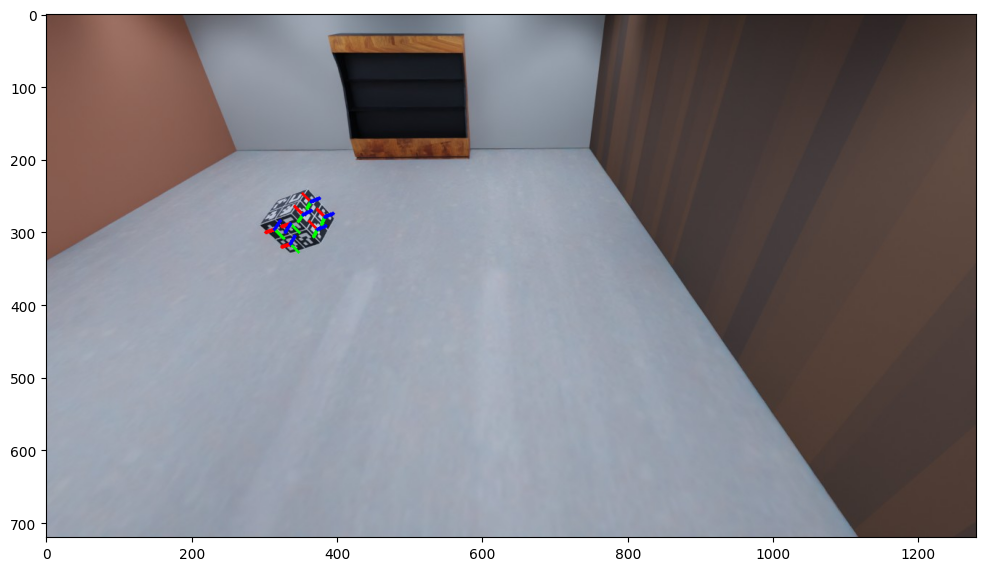

In [141]:

import cv2 as cv
from src.vican.vican.plot import detect_and_draw_charuco, detect_and_draw_aruco

%matplotlib inline

plt.figure(figsize=(12,12))

cam_id = "1"
time = "126"


for i in range(0, len(dataset.im_data["filename"])):
    if dataset.im_data["cam_id"][i] == cam_id and dataset.im_data["timestamp"][i] == time:
        idx = i
    
idx = np.random.randint(0, len(dataset.im_data["filename"]))

if 0:
    im = detect_and_draw_charuco(dataset.im_data["filename"][idx],
                                dataset.cams[cam_id],
                                charuco_dict,
                                test= np.array([[-np.pi/4],[np.pi/4],[-np.pi/2]]) )
    
else:
    im = detect_and_draw_aruco(dataset.im_data["filename"][idx],
                            'DICT_4X4_100',
                            dataset.cams[cam_id],
                            0,
                            0)

#undistort image
im = cv.undistort(im, dataset.cams[cam_id].intrinsics, dataset.cams[cam_id].distortion)

im = cv.cvtColor(im, cv.COLOR_BGR2RGB)

plt.imshow(im)
plt.show()

# Calibrate object

In [25]:
def recompute_edge(edge, aruco_obj, cam):

    marker_points = np.array([[-1, 1, 0],
                              [1, 1, 0],
                              [1, -1, 0],
                              [-1, -1, 0]], dtype=np.float32)
    
    marker_points *= aruco_obj["marker_size"] * 0.5

    flag, rvecs, tvecs, errors = cv.solvePnPGeneric(marker_points,
                                    imagePoints=edge["corners"],
                                    cameraMatrix=cam.intrinsics,
                                    distCoeffs=cam.distortion,
                                    flags=cv.SOLVEPNP_IPPE_SQUARE)
    
    rvec = rvecs[np.argmin(errors)]
    t = tvecs[np.argmin(errors)]
    
    # save the pose with the most reprojection error
    other_R = cv.Rodrigues(rvecs[np.argmax(errors)])[0]
    other_t = tvecs[np.argmax(errors)]
    other_pose = SE3(R=other_R, t=other_t)
            
    R = cv.Rodrigues(rvec)[0]
    pose = SE3(R=R, t=t)    
    
    return {'pose' : pose,
            'other_pose': other_pose,
            'other_error': errors[np.argmax(errors)].squeeze(),
            'corners' : edge["corners"], 
            'reprojected_err' : errors[np.argmin(errors)].squeeze(),
            'distance' : np.linalg.norm(t),
            'im_filename' : edge["im_filename"],
            "px_area": cv.contourArea(edge["corners"])}



In [108]:
if not LOAD:
    # This will compute camera-marker edges via PnP, in parallel
    aux = estimate_pose_mp(cams=obj_dataset.im_data['cam'],
                           im_filenames=obj_dataset.im_data['filename'],
                           target_dict = aruco_obj,
                           flags='SOLVEPNP_IPPE_SQUARE',
                           #target_dict = charuco_dict,
                           #flags='SOLVEPNP_IPPE',
                           brightness=0,
                           contrast=0)
    
    pickle.dump(aux, open(os.path.join(OBJ_DATASET_PATH, 'cube_calib_pose.pkl'), 'wb'))
    print("Saved")
else:
    if not GABRIEL:
        aux = pickle.load(open(os.path.join(OBJ_DATASET_PATH, 'cube_calib_pose.pkl'), 'rb'))
        print("Loaded")
    else: # load gabriel

        aux = pickle.load(open(os.path.join(OBJ_DATASET_PATH, 'cube_calib_pose.pkl'), 'rb'))
        for key, value in aux.items():

            aux[key] = recompute_edge(aux[key], aruco_obj, obj_dataset.cams[key[0]])
            #aux[key]["pose"] = SE3(pose=aux[key]["pose"])
            
        print("Loaded gabriel and converted into se3 obj")


Marker detection
Received 549 images.
Started pool of 8 workers.
Merging dictionaries...
Found markers in 493 images
Finished: 2297 markers detected.
Saved


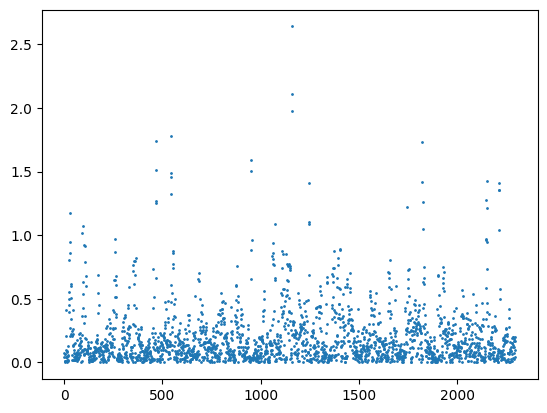

In [109]:
plt.figure()
data = np.array(  [ [edge["other_error"], edge["reprojected_err"]] for edge in aux.values() ] )

plt.plot(data[:,0]  - data[:,1], ".", markersize=2)
plt.show()

In [131]:
# Optimization - see extended paper

obj_pose_est = object_bipartite_se3sync(aux,
                                        noise_model_r=lambda edge : 0.01 * Polygon(zip(edge['corners'][:,0], edge['corners'][:,1])).area**1,
                                        noise_model_t=lambda edge : 0.01 * Polygon(zip(edge['corners'][:,0], edge['corners'][:,1])).area**1,
                                        #edge_filter=lambda edge : edge['reprojected_err'] < 0.2,
                                        edge_filter=lambda edge : np.abs (edge["other_error"] - edge["reprojected_err"] ) > 0.7,
                                        maxiter=4,
                                        lsqr_solver="conjugate_gradient",
                                        dtype=np.float64)


Received graph with 496 nodes 2297 edges
Applying constraints (0.015s).
Bipartite graph: 21 cameras, 36 timesteps, 91 edges.
Building 21x36 adjacency and 63x108 SO(3) sparse matrices (0.001s).
Building power graph (0.002s).


Optimizing:   0%|                                                         | 0/4 [00:00<?, ?it/s]

Building sparse 273x171 incidence matrix (0.019s).
Solving sparse linear system (0.002s).
Done!


# object edges errors

0.22824863
0.15666448


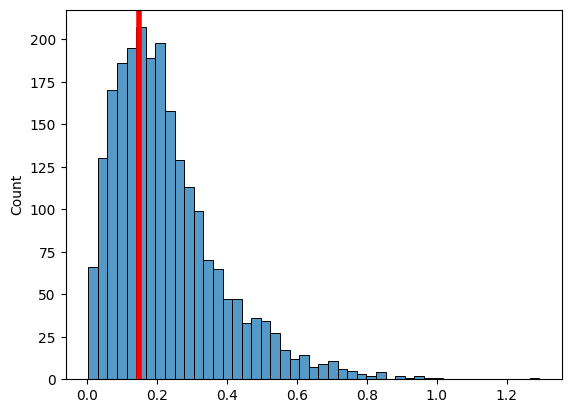

In [88]:
%matplotlib inline
# plot histogram of reprojected errors
sns.histplot([ edge['reprojected_err'].tolist() for edge in aux.values()])

# print the mean and std of the reprojected errors
print(np.mean([edge['reprojected_err'] for edge in aux.values()]))
print(np.std([edge['reprojected_err'] for edge in aux.values()]))

plt.axvline(x=0.15, linewidth=4, color='r')

plt.show()


# Detect markers & estimate camera-marker poses

In [71]:
#set cameras distortion coeefs to zero
for key, cam in dataset.cams.items():
    dataset.cams[key].distortion = np.zeros(5)

In [170]:
if not LOAD:
    # This will compute camera-marker edges via PnP, in parallel
    cam_marker_edges = estimate_pose_mp(cams=dataset.im_data['cam'],
                                        im_filenames=dataset.im_data['filename'],
                                        target_dict=aruco_obj,
                                        flags='SOLVEPNP_IPPE_SQUARE',
                                        #target_dict=charuco_dict,
                                        #flags='SOLVEPNP_IPPE',
                                        brightness=0,
                                        contrast=0)
    
    # Save it to use later, if necessary
    pickle.dump(cam_marker_edges, open(os.path.join(DATASET_PATH, 'cam_marker_edges.pkl'), 'wb'))
    print("Saved")
else:
    if not GABRIEL:
        
        cam_marker_edges = pickle.load(open(os.path.join(DATASET_PATH, 'cam_marker_edges.pkl'), 'rb'))
        print("Loaded")

    else: # load gabriel

        cam_marker_edges = pickle.load(open(os.path.join(DATASET_PATH, 'cam_marker_edges.pkl'), 'rb'))
        for key, value in cam_marker_edges.items():

            cam_marker_edges[key]["corners"] = np.round(cam_marker_edges[key]["corners"] * SCALE_GABRIEL)

            cam_marker_edges[key] = recompute_edge(cam_marker_edges[key], aruco_obj, dataset.cams[key[0]])
            #aux[key]["pose"] = SE3(pose=aux[key]["pose"])
            
        print("Loaded gabriel and converted into se3 obj")

Loaded gabriel and converted into se3 obj


# cam_marker errors

3.2775908413473287 1.1739056655604043


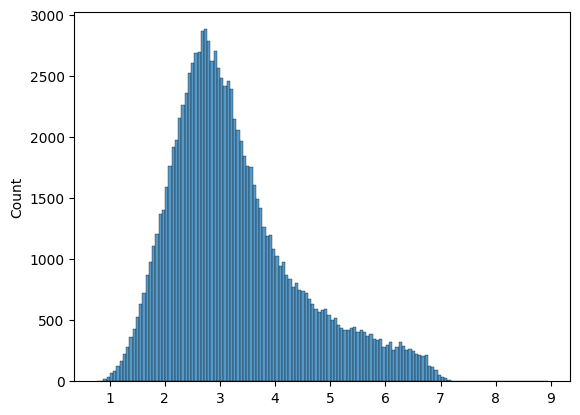

In [29]:
%matplotlib inline
plt.clf()
sns.histplot([edge['distance']for edge in cam_marker_edges.values()])

# print the mean and std of the reprojected errors
print(np.mean([edge['distance'] for edge in cam_marker_edges.values()]),
      np.std([edge['distance'] for edge in cam_marker_edges.values()]))

#plt.xlim((0,700))
plt.show()

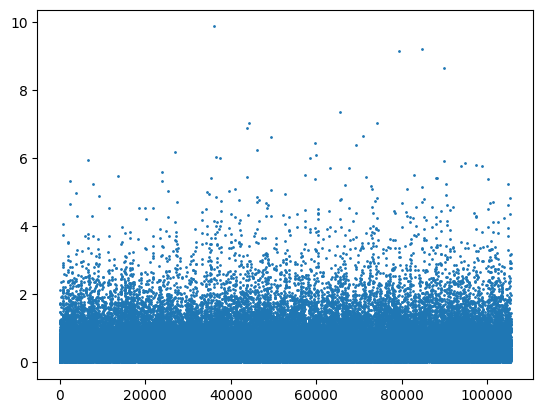

In [31]:
plt.figure()
data = np.array(  [ [edge["other_error"], edge["reprojected_err"]] for edge in cam_marker_edges.values() ] )

plt.plot(data[:,0]  - data[:,1], ".", markersize=2)
plt.show()


# Optimization

In [35]:
#remove edges that have been classified as masked out

new_edges = dict()

print("len before", len(cam_marker_edges))
print("len of mask out", len(mask_out))

for key in list(cam_marker_edges.keys()):
    if key in mask_out:
        
        #swap poses
        cam_marker_edges[key]["pose"], cam_marker_edges[key]["other_pose"] = cam_marker_edges[key]["other_pose"], cam_marker_edges[key]["pose"]
    
print("len after", len(cam_marker_edges))
        

len before 28429
len of mask out 4651
len after 28429


In [20]:
pose_est = bipartite_se3sync(cam_marker_edges,
                            constraints=obj_pose_est,
                            noise_model_r=lambda edge : 0.001 * Polygon(zip(edge['corners'][:,0], edge['corners'][:,1])).area**0.001,
                            noise_model_t=lambda edge : 0.001 * Polygon(zip(edge['corners'][:,0], edge['corners'][:,1])).area**0.001,
                            edge_filter=lambda edge : edge['reprojected_err'] < 20.0,
                            #edge_filter=lambda edge : edge['distance'] > 3.5,
                            #edge_filter=lambda edge : np.abs (edge["other_error"] - edge["reprojected_err"] ) > 0.35,
                            maxiter=4,
                            lsqr_solver="conjugate_gradient",
                            dtype=np.float32)

""" pose_est_filtered = bipartite_se3sync(cam_marker_edges,
                            constraints=obj_pose_st,
                            noise_model_r=lambda edge : 0.0001 * Polygon(zip(edge['corners'][:,0], edge['corners'][:,1])).area**0.0001,
                            noise_model_t=lambda edge : 0.0001 * Polygon(zip(edge['corners'][:,0], edge['corners'][:,1])).area**0.0001,
                            #edge_filter=lambda edge : edge['reprojected_err'] < 0.25,
                            #edge_filter=lambda edge : edge['distance'] < 3.0,
                            edge_filter=lambda edge : np.abs (edge["other_error"] - edge["reprojected_err"] ) > 0.25,
                            maxiter=20,
                            lsqr_solver="conjugate_gradient",
                            dtype=np.float32)
 """

Received graph with 40323 nodes 105543 edges
Applying constraints (5.755s).
Bipartite graph: 25 cameras, 6477 timesteps, 35453 edges.
Building 25x6477 adjacency and 75x19431 SO(3) sparse matrices (0.327s).
Building power graph (0.041s).


Optimizing:   0%|                                              | 0/4 [00:00<?, ?it/s]

Building sparse 316629x19506 incidence matrix (15.184s).
Solving sparse linear system (0.150s).
Done!


' pose_est_filtered = bipartite_se3sync(cam_marker_edges,\n                            constraints=obj_pose_st,\n                            noise_model_r=lambda edge : 0.0001 * Polygon(zip(edge[\'corners\'][:,0], edge[\'corners\'][:,1])).area**0.0001,\n                            noise_model_t=lambda edge : 0.0001 * Polygon(zip(edge[\'corners\'][:,0], edge[\'corners\'][:,1])).area**0.0001,\n                            #edge_filter=lambda edge : edge[\'reprojected_err\'] < 0.25,\n                            #edge_filter=lambda edge : edge[\'distance\'] < 3.0,\n                            edge_filter=lambda edge : np.abs (edge["other_error"] - edge["reprojected_err"] ) > 0.25,\n                            maxiter=20,\n                            lsqr_solver="conjugate_gradient",\n                            dtype=np.float32)\n '

# Cameras D Plot

In [129]:
def plot_frame(ax, H, label, scale=0.02, color = 'k'):
    origin = H[:3, 3]
    x_axis = H[:3, 0]
    y_axis = H[:3, 1]
    z_axis = H[:3, 2]

    ax.quiver(*origin, *x_axis, color='r', length=scale, normalize=True)
    ax.quiver(*origin, *y_axis, color='g', length=scale, normalize=True)
    ax.quiver(*origin, *z_axis, color='b', length=scale, normalize=True)
    ax.text(*origin, label, fontsize=12, color=color)

-0.013597354
time 3471
cam 7
ids in view ['22', '23']
[[-0.9761804   0.10595423 -0.1893294   2.1857698 ]
 [-0.01160625  0.84589225  0.53322756 -0.16957712]
 [ 0.21665     0.5227237  -0.8245137   3.2159348 ]
 [ 0.          0.          0.          1.        ]]
-0.15712291
time 3471
cam 7
ids in view ['22', '23']
[[-0.5866501  -0.41678256 -0.69435865  1.9841733 ]
 [-0.04131579  0.87168825 -0.48831615 -0.18367687]
 [ 0.8087859  -0.25778273 -0.5285957   3.4055119 ]
 [ 0.          0.          0.          1.        ]]


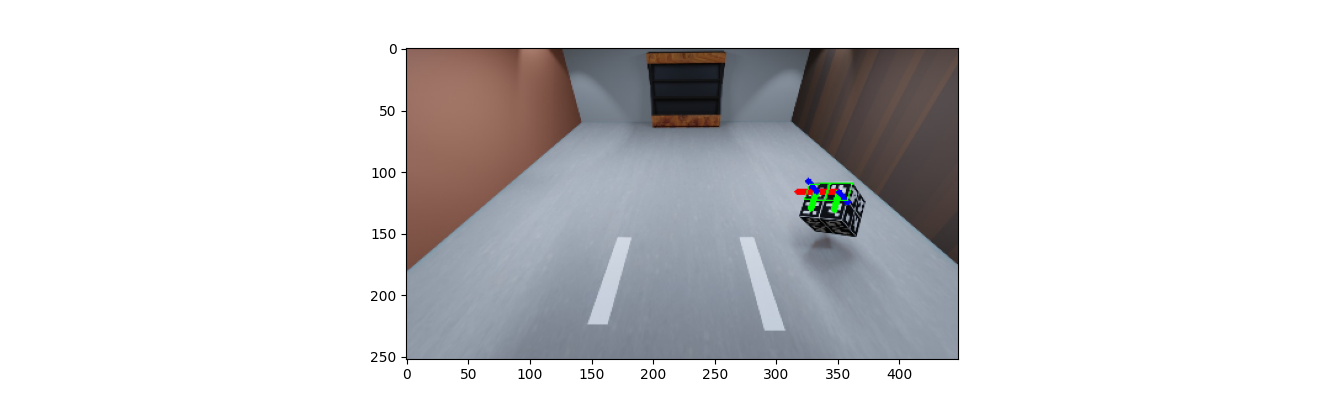

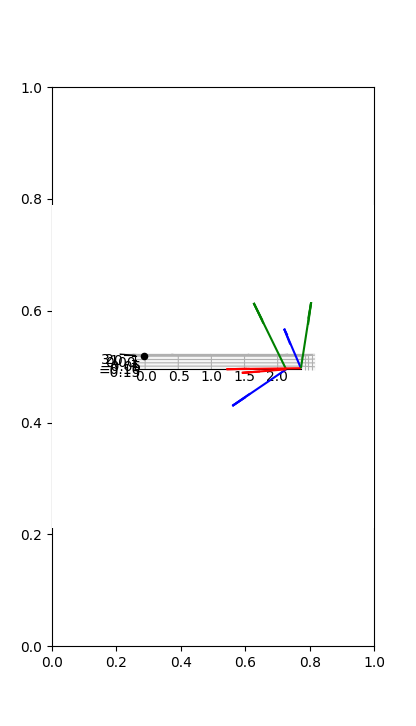

In [172]:
import random 
from src.vican.vican.plot import draw_marker

%matplotlib widget

times = np.array([key[1].split("_")[0] for key in cam_marker_edges.keys()])

plt.clf()
plt.cla()
plt.figure(1,figsize=(15,15))
plt.figure(2,figsize=(3,3))
plt.figure(2)
ax = plt.subplot(111, projection='3d')

while True: 

    time = np.random.choice(times)

    cams = []

    for i in os.walk(os.path.join(DATASET_PATH, time)):
        _, _, files = i
        cams = [file.split(".")[0] for file in files if file.endswith(".jpg")]


    cam = np.random.choice(cams)

    time = "3471"
    cam = "7"

    rx = dataset.cams[cam].resolution_x
    ry = dataset.cams[cam].resolution_y

    # check what markers are in view in this timestep and camera
    possibilities = [(cam, time+"_"+marker_id) for marker_id in aruco_obj["marker_ids"]]

    ids_in_view = [key[1].split("_")[1] for key in cam_marker_edges.keys() if key in possibilities]
    distances = [cam_marker_edges[key]["distance"] for key in cam_marker_edges.keys() if key in possibilities]

    """ if not ( len(ids_in_view) > 3 and np.sum(np.greater(distances, 1)) >= 1 ):
        continue """
    
    im = cv.resize(cv.imread(os.path.join(DATASET_PATH, time, cam+".jpg")), (rx, ry))

    to_cont = 0
    to_break = 0

    for id in ids_in_view:

        to_draw = cam_marker_edges[(cam, time+"_"+id)]

        if np.abs(to_draw["reprojected_err"]- to_draw["other_error"]) < 0.05:
            pass
        else:
            pass
        
        #if to_cont:
            #break

        im = cv.drawFrameAxes(im, dataset.cams[cam].intrinsics, dataset.cams[cam].distortion, to_draw["pose"].R(),
                            to_draw["pose"].t(), length=0.3)
        
        im = draw_marker(im, to_draw["corners"],"")
        print(to_draw["reprojected_err"] - to_draw["other_error"])

        to_break = 1

        print("time", time)
        print("cam", cam)
        print("ids in view", ids_in_view)

        plt.figure(2)
        print(to_draw["pose"].pose())
        plot_frame(ax, to_draw["pose"].pose(), " ",scale=1, color='r')
        plt.figure(1)


    im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
    plt.imshow(im)

    if to_break:
        break

ax.scatter(0, 0, 0, color='k')
ax.set_aspect('equal')
ax.view_init(elev=90, azim=-90, roll = 0) 
plt.show()
plt.figure(2)
plt.show()

(4, 21)

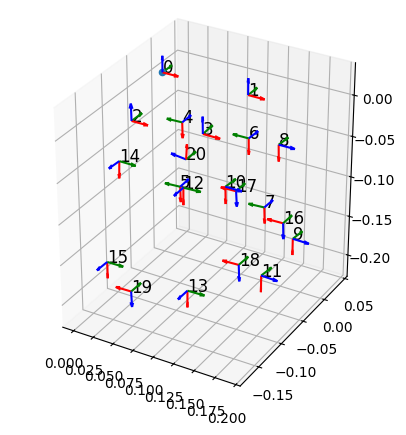

In [132]:

%matplotlib inline
#%matplotlib widget

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(projection='3d')

is_charuco = False

wrl_id = "0"
pts_wrld = []
for marker_id, pose in obj_pose_est.items():
    
    if ("_" in marker_id):
        continue
    
    plot_frame(ax, obj_pose_est[wrl_id].inv().pose() @ obj_pose_est[marker_id].pose()  , marker_id) 
    
    #draw the chessbaord corners in space for each charuco board
    if is_charuco:
        for i in range(1,charuco_dict[marker_id]["sizeX"]):
            for j in range(1, charuco_dict[marker_id]["sizeY"]):
                
                if marker_id == "0":
                    ax.scatter( i * charuco_dict[marker_id]["squareLength"], j * charuco_dict[marker_id]["squareLength"], 0)
                    pts_wrld.append([i*charuco_dict[marker_id]["squareLength"], j*charuco_dict[marker_id]["squareLength"], 0])
                    
                    ax.text(i*charuco_dict[marker_id]["squareLength"], j*charuco_dict[marker_id]["squareLength"], 0, f"{ j * (charuco_dict[marker_id]['sizeY'] - 2) + i }")
                    
                else:
                    #continue
                    # transform the points to the "0" frame
                    point = obj_pose_est[wrl_id].inv()._pose @ obj_pose_est[marker_id]._pose @  np.array([i*charuco_dict[marker_id]["squareLength"], j*charuco_dict[marker_id]["squareLength"], 0, 1])
                    ax.scatter(point[0], point[1], point[2])
                    pts_wrld.append(point[:3])
                    
    else:
        
        marker_in_wrld = obj_pose_est[wrl_id].inv().pose() @ obj_pose_est[marker_id].pose()
        pts_wrld.append(marker_in_wrld[:3, 3])
            
                    
                

# draw the rest of the cube
ax.scatter(0,0,0)
# aspect ratio of the plot to be equal
ax.set_aspect('equal')

#ax.view_init(elev=0, azim=90, roll=0)

# show the plot
#plt.show()


# object in marker 0 frame in homogenous coordinates
pts_wrld = np.array(pts_wrld)
pts_wrld = np.vstack( [pts_wrld.T, np.ones(pts_wrld.shape[0]) ] )
pts_wrld.shape

#pts_wrld = np.array([[ 0, 0,0, 1]]).T
#pts_wrld.shape

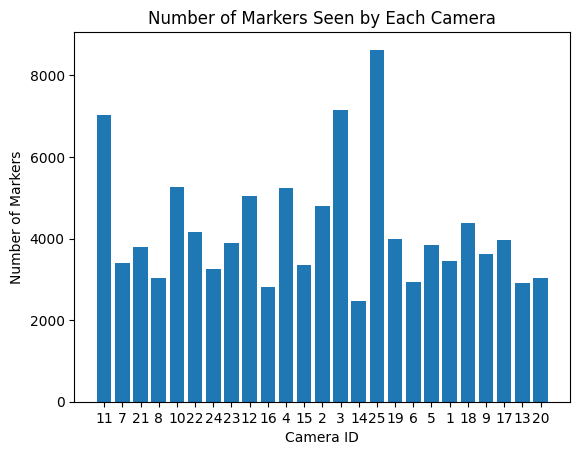

In [81]:
%matplotlib inline

import matplotlib.pyplot as plt

# Count the number of markers for each camera
marker_counts = {}
for cam_id, _ in cam_marker_edges.items():

    cam_id = cam_id[0]  # Extract the camera ID
    
    if cam_id in marker_counts:
        marker_counts[cam_id] += 1
    else:
        marker_counts[cam_id] = 1

# Create the histogram
plt.figure()
plt.bar(marker_counts.keys(), marker_counts.values())
plt.xlabel('Camera ID')
plt.ylabel('Number of Markers')
plt.title('Number of Markers Seen by Each Camera')
plt.show()

# Plot cameras in 3D Space

In [80]:
from src.vican.vican.geometry import SE3, rotz
from src.vican.vican.plot import plot_cams_3D

for cam_id, cam in dataset.cams.items():
    
    try:
        cam.extrinsics = pose_est[cam_id]
    except:
        continue

pos_obj = [pose.t().tolist() for cam_id, pose in pose_est.items() if "_" in cam_id] 

pos_obj = np.array(pos_obj)

plot_cams_3D(dataset.cams.values(), pos_obj)

Saving to output.html


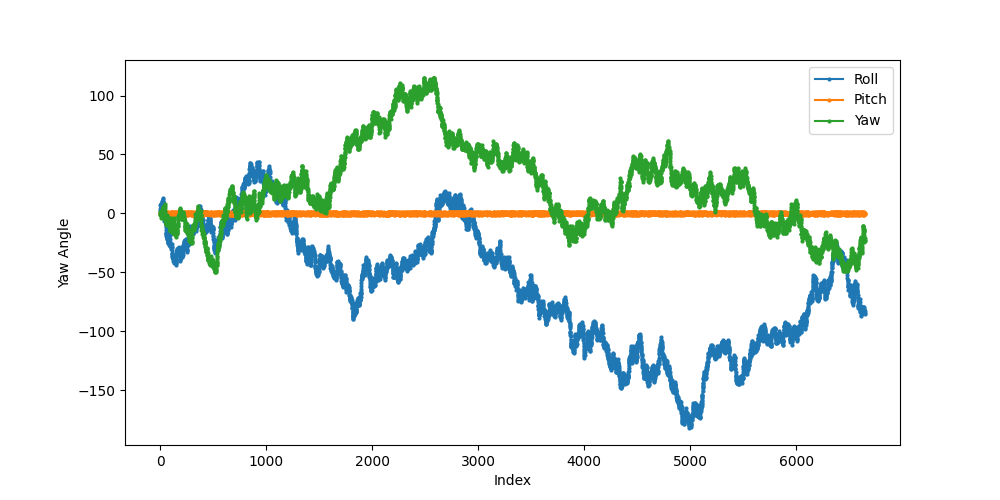

In [51]:
%matplotlib widget
from scipy.spatial.transform import Rotation

plt.figure(figsize=(10,5))  


angles = []
#position = dict()

for tuple_id, pose in pose_est.items():
    
    if "_" in tuple_id:
        #print(tuple_id.split("_")[1])
        #print(pose)
        
        rot_mat = pose.R()
        angles.append(np.hstack((Rotation.from_matrix(rot_mat).as_euler('xyz'), int(tuple_id.split("_")[0]) ) ) )
        

angles = np.array(angles)
angles = angles[angles[:, -1].argsort()] # sort by time
angles[:, :3] = np.unwrap(angles[:, :3], axis=0)

plt.plot(angles[:,-1], angles[:,0],"-o", label='Roll', markersize=2)
plt.plot(angles[:,-1], angles[:,1],"-o", label='Pitch', markersize=2)
plt.plot(angles[:,-1], angles[:,2],"-o", label='Yaw', markersize=2)
plt.xlabel('Index')
plt.ylabel('Yaw Angle')
#plt.xlim((100, 300))
#plt.ylim((-20,10))
plt.legend()
plt.show()


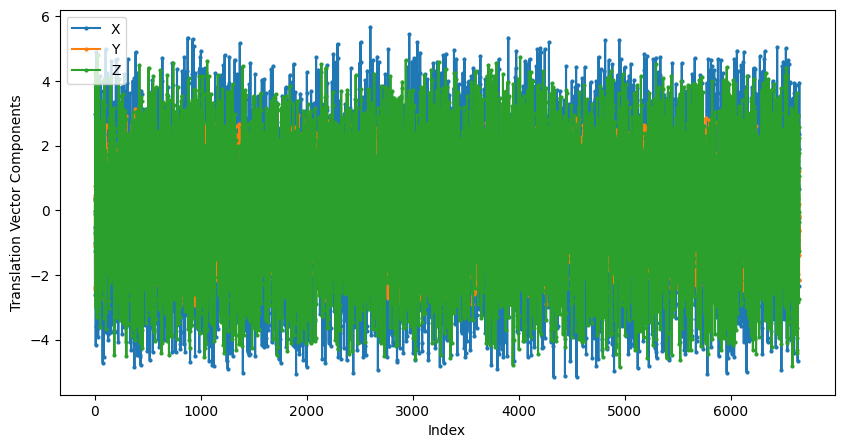

In [85]:
%matplotlib inline

plt.figure(figsize=(10,5))  

translations = []

for tuple_id, pose in pose_est.items():
    if "_" in tuple_id:
        t_vec = pose.t()
        translations.append(np.hstack((t_vec, int(tuple_id.split("_")[0]))))

translations = np.array(translations)
translations = translations[translations[:, -1].argsort()]  # sort by time

plt.plot(translations[:, -1], translations[:, 0], "-o", label='X', markersize=2)
plt.plot(translations[:, -1], translations[:, 1], "-o", label='Y', markersize=2)
plt.plot(translations[:, -1], translations[:, 2], "-o", label='Z', markersize=2)
plt.xlabel('Index')
plt.ylabel('Translation Vector Components')
plt.legend()
plt.show()

In [94]:
def find_im_idx(cam_id, timestep, dataset):
    for i in range(0, len(dataset.im_data["filename"])):
        if dataset.im_data["cam_id"][i] == cam_id and dataset.im_data["timestamp"][i] == time:
            idx = i
            break

    return idx

In [143]:
from src.vican.vican.geometry import SE3
from tqdm import tqdm

wrl_id = "0"
to_break = 0
theta_limit = 1.0
mask_out = []

for tuples, pose in tqdm(pose_est.items(), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'):
    if "_" in tuples:
        time = tuples.split("_")[0]
        edges_visible = dict()

        for cam in list(dataset.cams.keys()):
            for marker_id in obj_pose_est.keys():
                try:
                    edges_visible[(cam, marker_id)] = cam_marker_edges[(cam, time+"_"+marker_id)]
                except:
                    pass
            
        
        # per timestamp
        for key, edges_visible in edges_visible.items():
            #print(pose_est[key[0]].inv().pose() @ pose_est[time+"_"+wrl_id].pose())
            if key[0] == "0":
                continue

            marker_cam_frame = SE3(pose=pose_est[key[0]].inv().pose() @ pose_est[time+"_"+wrl_id].pose() @ obj_pose_est[wrl_id].inv().pose() @ obj_pose_est[key[1]].pose())

            R_diff = marker_cam_frame.R().T @ edges_visible["pose"].R()

            theta = np.arccos((np.trace(R_diff) - 1) / 2)
            #print(time, key[0], key[1],theta)

            if theta > theta_limit:
                mask_out.append((key[0], time+"_"+key[1]))

            if theta > theta_limit and np.linalg.norm(edges_visible["pose"].t()) > 5.0  and 1:
                im = cv.imread(edges_visible["im_filename"])
                im = cv.drawFrameAxes(im, dataset.cams[key[0]].intrinsics, dataset.cams[key[0]].distortion, tvec=edges_visible["pose"].t(),
                                    rvec=edges_visible["pose"].R(), length=0.1)
                im = cv.drawFrameAxes(im, dataset.cams[key[0]].intrinsics, dataset.cams[key[0]].distortion,
                                    tvec=marker_cam_frame.t(), rvec=cv.Rodrigues(marker_cam_frame.R())[0], length=0.1)
                #im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
                cv.imwrite(f"test_images/{time}_{key[0]}_{key[1]}.jpg", im)
                

print(len(mask_out))
print(len(cam_marker_edges))

        

  9%|▉         | 71/808 [00:00<00:03, 185.63it/s]                                                                                  /tmp/ipykernel_10/3188796426.py:32: RuntimeWarning:

invalid value encountered in arccos

100%|██████████| 808/808 [00:06<00:00, 125.82it/s]                                                                                 

4587
28429


Text(0, 0.5, 'Rotation')

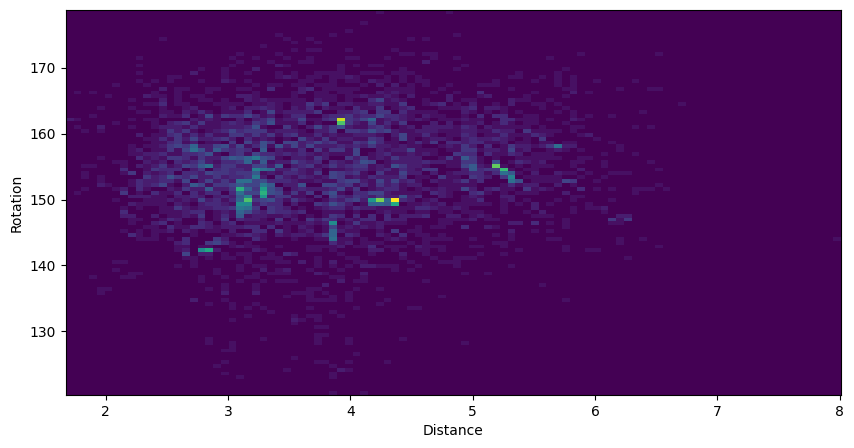

In [148]:
# Extract distances of masked out edges
masked_out_distances = [cam_marker_edges[key]['distance'] for key in mask_out]

# Create a scatter plot of the distances
plt.figure(figsize=(10, 5))
norm_rot = [np.rad2deg(np.arccos((np.trace(cam_marker_edges[key]['other_pose'].R()) - 1) / 2))  for key in mask_out]
dist_sols = [np.abs(cam_marker_edges[key]['other_error'] -cam_marker_edges[key]['reprojected_err'])for key in mask_out]
plt.hist2d(masked_out_distances, norm_rot, bins=100, cmap='viridis')
plt.xlabel('Distance')
plt.ylabel('Rotation')


# Marker projected in image space after optimization

## Charuco list

In [80]:
charuco_list = []
for i in range(0,charuco_dict["num_boards"] + 1):
        
    charuco_board = cv.aruco.CharucoBoard(
        size=(charuco_dict[str(i)]["sizeX"], charuco_dict[str(i)]["sizeY"]),
        squareLength=charuco_dict[str(i)]["squareLength"],
        markerLength=charuco_dict[str(i)]["markerLength"],
        dictionary= cv.aruco.getPredefinedDictionary(charuco_dict[str(i)]["dictionary"]),
        ids=charuco_dict[str(i)]["ids"])
    
    charuco_board.setLegacyPattern(True)
    charuco_list.append(charuco_board)      
    
    
charuco_list[0]

< cv2.aruco.CharucoBoard 0x7fa8cbaaddb0>

## Projection

In [124]:
%matplotlib inline
import os
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

def process_image(i):
    timestep = dataset.im_data["timestamp"][i]
    cam_id = dataset.im_data["cam_id"][i]
    
    try:
        #xyz_0 into wrld frame
        xyz_wrl = pose_est[f"{timestep}_0"]._pose @ pts_wrld
    except:
        #print("timestep not found")
        return
    
    # k [ R^T | -R^T*t] = P
    if 0: 
        # its better to use the opencv projectpoinrs since it uses the distortion model
        cam_model = np.array( dataset.im_data["cam"][i].intrinsics
                            @ 
                            np.concatenate( ( pose_est[cam_id].R().T , -1 * pose_est[cam_id].R().T @ np.array([pose_est[cam_id].t()]).T ) , axis=1) )   # in camera frame

        # 3d points in marker0 frame into frame camera
        uv_0 = cam_model @ xyz_wrl

        # normalize homogenous coordinates
        uv_0 = uv_0[:2,:]/ uv_0[2,:]
    else:
        # pose est brings from camera to wrld frame
        uv_0 = cv.projectPoints(objectPoints=xyz_wrl[:3 , :], rvec=cv.Rodrigues(pose_est[cam_id].R().T)[0], tvec=-1*pose_est[cam_id].R().T @ pose_est[cam_id].t(),
                                cameraMatrix=dataset.cams[cam_id].intrinsics, distCoeffs=dataset.cams[cam_id].distortion)[0].squeeze().T
        
    im = cv.imread(dataset.im_data["filename"][i])
    
    # draw charuco detections
    if is_charuco:
        for board in charuco_list:
            
            corners, ids, rejected = cv.aruco.detectMarkers(im, board.getDictionary())
            if len(corners) > 0:
                retval, charuco_corners, charuco_ids = cv.aruco.interpolateCornersCharuco(corners, ids, im, board)
                if retval:
                    for z in charuco_corners:
                        z =  z.squeeze()
                        im = cv.circle(im, (int(z[0]), int(z[1])), 1, (0, 0, 255), 1)
    
    # draw the reprojected points from a known object structure
    try:
        for j in range(uv_0.shape[1]):
            im = cv.circle(im, (int(uv_0[0,j]), int(uv_0[1,j])), 1, (0,255,0), 1)
    except:# just one pt
        im = cv.circle(im, (int(uv_0[0]), int(uv_0[1])), 1, (0,255,0), 1)
        
    cube_in_cam_frame = pose_est[timestep + "_0"].inv() @ pose_est[cam_id]
    cube_in_cam_frame = cube_in_cam_frame.inv()
    
    im = cv.drawFrameAxes(im, dataset.cams[cam_id].intrinsics, dataset.cams[cam_id].distortion,
                          cv.Rodrigues(cube_in_cam_frame.R())[0], cube_in_cam_frame.t(), 0.1)
            
    
    # Create folder if it doesn't exist
    folder_path = f"test_images/{cam_id}"
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        
    cv.imwrite(f"test_images/{cam_id}/{timestep}.png", im)

# Use ThreadPoolExecutor to run the loop in multiple threads
num_threads = 8  # You can change this number to the desired number of threads

with ThreadPoolExecutor(max_workers=num_threads) as executor:
    list(tqdm(executor.map(process_image, range(len(dataset.im_data["filename"]))), total=len(dataset.im_data["filename"]), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'))


100%|██████████| 8010/8010 [00:36<00:00, 220.85it/s]                                                                               


# projection with pre-computed edges

In [56]:
def get_image_idx(cam_id, time):
    
    idx = None
    for i in range(0, len(dataset.im_data["filename"])):
        if dataset.im_data["cam_id"][i] == cam_id and dataset.im_data["timestamp"][i] == time:
            idx = i
            
    return idx

In [ ]:
%matplotlib inline

from src.vican.vican.geometry import SE3

plt.figure(figsize=(12,12))
resX = dataset.im_data["cam"][0].resolution_x 
resY = dataset.im_data["cam"][0].resolution_y

for identifier,edge in cam_marker_edges.items():
    
    mosaic = np.zeros( (resX, resY * len(dataset.cams), 3), dtype=np.uint8)
    
    #skip a random number of items in the dictionary
    #if np.random.rand() > 0.01:
    #    continue
    
    cam_id = identifier[0]
    timestep = identifier[1].split('_')[0]
    marker_id = identifier[1].split('_')[1]
    
    #if marker_id != "0":
    #    continue
    
    #if timestep != "144":
    #    continue
    
    
    # find image index in dataset
    im_idx = get_image_idx(cam_id, timestep)
    if im_idx == None:
        continue
    
    # find the ids of other cameras
    other_cam_ids = [k for k in dataset.cams.keys() if k != cam_id]
    
    # find the image index of the other cameras
    other_imgs_idx = [get_image_idx(k, timestep) for k in other_cam_ids]
    
    im = cv.imread(dataset.im_data["filename"][im_idx])
    
    # represent the object pts in the detected marker frame - "0" frame is the root object frame
    pts_detect_frame = obj_pose_est[marker_id].inv().pose() @ obj_pose_est["0"].pose() @ pts_wrld
    #pts_detect_frame = pts_detect_frame[:3,:] / pts_detect_frame[3,:] # normalize homogenous coordinates
    

    uv_marker = cv.projectPoints(pts_detect_frame[:3, :] / pts_detect_frame[3,:],
                                 edge['pose'].R(),
                                 edge['pose'].t(),
                                 dataset.im_data["cam"][im_idx].intrinsics,
                                 dataset.im_data["cam"][im_idx].distortion)[0].squeeze()
    
    
    #go through all other cameras and draw the reprojected points
    for idx in other_imgs_idx:
        
        new_im = cv.imread(dataset.im_data["filename"][idx])
        
        # change referencial to other camera 
        tf_new_cam =SE3 ( pose = pose_est[dataset.im_data["cam_id"][idx]].inv().pose() @ pose_est[cam_id].pose() @ edge["pose"].pose() )
        
        
        markers_other_cam = cv.projectPoints(pts_detect_frame[:3, :] / pts_detect_frame[3,:],
                                            tf_new_cam.R().astype(np.float64),
                                            tf_new_cam.t().astype(np.float64),
                                            dataset.im_data["cam"][idx].intrinsics,
                                            dataset.im_data["cam"][idx].distortion)[0].squeeze()
        
        
        for i in range(markers_other_cam.shape[0]):
            new_im = cv.circle(new_im, (int(markers_other_cam[i,0]), int(markers_other_cam[i,1])), 2, (0,255,0), 2)
            
        # append new_im to im
        mosaic[:resX ,int( dataset.im_data["cam_id"][idx] ) * resY : int( dataset.im_data["cam_id"][idx]) * resY + resY, :] = new_im
        
    
    #im = cv.drawFrameAxes(im, cameraMatrix=dataset.im_data["cam"][im_idx].intrinsics,
    #                      distCoeffs=dataset.im_data["cam"][im_idx].distortion,
    #                      rvec=edge['pose'].R(),
    #                      tvec=edge['pose'].t(),
    #                      length=0.12)
    
    for i in range(uv_marker.shape[0]):
        im = cv.circle(im, (int(uv_marker[i,0]), int(uv_marker[i,1])), 2, (0,0,255), 2)
    
    mosaic[:resX , int(cam_id) * resY : int(cam_id) * resY + resY, :] = im
    
    cv.imwrite(f"test_images/mosaic_{timestep}_{cam_id}_{marker_id}.png", mosaic)
       

    